# Autoregressive Models - PixelCNN

The autoregressive models are generative models that provides an explicit parametric specification of a likelihood function of a variable by specifying it with its parameters. However, to model data that have several dimensions/features, autoregressive models need to define some constraints. First, the observation space X need to have a determining ordering for its features. Second, to tractably model the joint distribution of the features in a data observation ($p(x)$), the autoregressive approach cast $p(x)$ as a product of conditional distributions. Autoregressive models define the joint distribution using conditionals over each feature given the values of the previous features. This way, autoregressive models use the chain rule to decompose the likelihood of the data sample x into a product of 1-dimensional distributions. The factorization turns the joint modelling problem into a sequence problem, where one learns to predict the next pixel given all the previously generated pixels.

<center><img src="https://github.com/Mind-the-Pineapple/Autoregressive-models/blob/master/1%20-%20Autoregressive%20Models%20-%20PixelCNN/figures/Figure3.png?raw=1" width="250"  align="middle"></center>


## PixelCNN
PixelCNN was introduced by DeepMind in 2016 (Oord et al, 2016) and it started one of the most promising families of autoregressive generative models. PixelCNN is a deep neural network that captures the distribution of dependencies between pixels in the parameters. It sequentially generates one pixel at a time in an image along the two spatial dimensions.


In this implementation, we used the new Tensorflow 2.0 framework. In the first step we install and import the code dependencies.

In [ ]:
%tensorflow_version 2.x

In [1]:
import random as rn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import nn
from tensorflow.keras import initializers
from tensorflow.keras.utils import Progbar

Then, we define the random seeds to have reproducible results and we load the MNIST dataset to train the PixelCNN.

In [2]:
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)

In [3]:
# Loading data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

height = 28
width = 28
n_channel = 1

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape[0], height, width, n_channel)
x_test = x_test.reshape(x_test.shape[0], height, width, n_channel)

In this example, to make the probability distribution of a single pixel easier to be defined, we decide to quantitise the number of possible values that a pixel could have. Originally, in the MNIST dataset the pixels are represented by a uint8 variable, beeing able assume values between [0, 255]. In this example, we restrict the image to have only 2 different values ([0, 1]).

In [4]:
def quantise(images, q_levels):
    """Quantise image into q levels"""
    return (np.digitize(images, np.arange(q_levels) / q_levels) - 1).astype('float32')

In [5]:
# Quantise the input data in q levels
q_levels = 2
x_train_quantised = quantise(x_train, q_levels)
x_test_quantised = quantise(x_test, q_levels)

Using the tensorflow.Data API, we defined the input data streams for our model during the training and the evaluation. In these dataset, we define the inputs as the images with 2 levels normalized to be between [0, 1] and the target values are the categoricals pixels values between [0, 1].

In [6]:
# Creating input stream using tf.data API
batch_size = 256
train_buf = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)

## Masked Convolutions

When using the convolution operations, PixelCNN can parallelly learn the distribution of all pixels in the image. However, the receptive field of a standard convolutional violates the sequential prediction of autoregressive models. When processing the data of a central pixel, the convolutional filter considers all the pixels around it to calculate the output feature map, not only the previous pixels. 

To solve this problem, **masks** are adopted to block information flow from the future pixels.

Masking can be done by zeroing out all the pixels that should not be considered. In our implementation, a mask with the same size to the convolutional filter with values 1 and 0 was created. This mask was multiplied with the weight tensor before doing the convolution operation.

In the pixelCNN, there are two types of masks: type A and type B.

*	**Mask A**: this mask is applied only to the first convolutional layer. It restricts access to the pixel of interest by zeroing the center pixel in mask. This way, we guarantee model will not access the pixel that it is about to predict. 

*	**Mask B**: This mask is applied to all the subsequent convolutional layers and relaxes the restrictions of mask A by allowing the connection from a pixel to itself. 

Below, we have the masks defined inside a keras layer named MaskedConv2D. In this layer, besides the parameters weigths and bias, we have the constant mask defining the pixels to be zeroed and the type of mask (A or B) (Lines 60 to 66).

Finally, the mask is applied before the convolution (Line 69).


In [7]:
class MaskedConv2D(keras.layers.Layer):
    """Convolutional layers with masks.

    Convolutional layers with simple implementation of masks type A and B for
    autoregressive models.

    Arguments:
    mask_type: one of `"A"` or `"B".`
    filters: Integer, the dimensionality of the output space
        (i.e. the number of output filters in the convolution).
    kernel_size: An integer or tuple/list of 2 integers, specifying the
        height and width of the 2D convolution window.
        Can be a single integer to specify the same value for
        all spatial dimensions.
    strides: An integer or tuple/list of 2 integers,
        specifying the strides of the convolution along the height and width.
        Can be a single integer to specify the same value for
        all spatial dimensions.
        Specifying any stride value != 1 is incompatible with specifying
        any `dilation_rate` value != 1.
    padding: one of `"valid"` or `"same"` (case-insensitive).
    kernel_initializer: Initializer for the `kernel` weights matrix.
    bias_initializer: Initializer for the bias vector.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B'}
        self.mask_type = mask_type

        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        self.kernel = self.add_weight('kernel',
                                      shape=(self.kernel_size,
                                             self.kernel_size,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight('bias',
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)

        center = self.kernel_size // 2

        mask = np.ones(self.kernel.shape, dtype=np.float32)
        mask[center, center + (self.mask_type == 'B'):, :, :] = 0.
        mask[center + 1:, :, :, :] = 0.

        self.mask = tf.constant(mask, dtype=tf.float32, name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = nn.conv2d(input,
                      masked_kernel,
                      strides=[1, self.strides, self.strides, 1],
                      padding=self.padding)
        x = nn.bias_add(x, self.bias)
        return x

## Residual blocks

Another element that compose the PixelCNN architecture is the residual blocks.

In [8]:
class ResidualBlock(keras.Model):
    """Residual blocks that compose pixelCNN

    Blocks of layers with 3 convolutional layers and one residual connection.
    Based on Figure 5 from [1] where h indicates number of filters.

    Refs:
    [1] - Oord, A. V. D., Kalchbrenner, N., & Kavukcuoglu, K. (2016). Pixel recurrent
    neural networks. arXiv preprint arXiv:1601.06759.
    """

    def __init__(self, h):
        super(ResidualBlock, self).__init__(name='')

        self.conv2a = keras.layers.Conv2D(filters=h, kernel_size=1, strides=1)
        self.conv2b = MaskedConv2D(mask_type='B', filters=h, kernel_size=3, strides=1)
        self.conv2c = keras.layers.Conv2D(filters=2 * h, kernel_size=1, strides=1)

    def call(self, input_tensor):
        x = nn.relu(input_tensor)
        x = self.conv2a(x)

        x = nn.relu(x)
        x = self.conv2b(x)

        x = nn.relu(x)
        x = self.conv2c(x)

        x += input_tensor
        return x

## PixelCNN architecture

In Oord et al. 2016, the PixelCNN uses the following architecture.

<center><img src="https://github.com/Mind-the-Pineapple/Autoregressive-models/blob/master/1%20-%20Autoregressive%20Models%20-%20PixelCNN/figures/Figure5_Architecture.png?raw=1" width="700"></center>

The first layer is a masked convolution (type A) with 7x7 filters. Then, 15 residual blocks were used. Each block processes the data with a combination of 3x3 layers convolutional layers with mask type B and 1x1 standard convolutional layers. Between each convolutional layer there is also a non-linearity ReLU. After these layers, a residual connection is added. Finally, the network has a sequence of RELU-CONV-RELU-CONV using standard convolutional layers, where both have 1x1 filters. Then, the output layer is a softmax layer which predicts the value among all possible values of a pixel (the output softmax layer is omitted in our network). So, this softmax layer had the image dimension (because we want an output value for each pixel) times the number of possible values (for example, 256 pixels values).

In [9]:
# Create PixelCNN model
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=128, kernel_size=7, strides=1)(inputs)

for i in range(15):
    x = ResidualBlock(h=64)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=q_levels, kernel_size=1, strides=1)(x)

pixelcnn = keras.Model(inputs=inputs, outputs=x)

In this implementation we use a simple Adam optimizer with learning rate decay to train the neural network. The loss function is defined by the cross-entropy (that in this case is equivalent to minimizing the negative log-likelihood of the training data).

In [10]:
# Prepare optimizer and loss function
lr_decay = 0.999995
learning_rate = 1e-3
optimizer = keras.optimizers.Adam(lr=learning_rate)

compute_loss = keras.losses.CategoricalCrossentropy(from_logits=True)

The training step is defined by the forward propagation through the model. Then, the gradients are calculated, clipped to be between [-1, 1], and applied to upgrade the PixelCNN parameters.

In [11]:
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn(batch_x, training=True)

        loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))

    return loss

In this implementation, we defined the training loop with 100 epochs.

In [12]:
# Training loop
n_epochs = 100
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    progbar = Progbar(n_iter)
    print('Epoch {:}/{:}'.format(epoch + 1, n_epochs))

    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)

        progbar.add(1, values=[('loss', loss)])

Epoch 1/100
235/235 [==============================] - 72s 307ms/step - loss: 0.1136
Epoch 2/100
235/235 [==============================] - 65s 277ms/step - loss: 0.0887
Epoch 3/100
235/235 [==============================] - 67s 283ms/step - loss: 0.0860
Epoch 4/100
235/235 [==============================] - 66s 279ms/step - loss: 0.0842
Epoch 5/100
235/235 [==============================] - 65s 278ms/step - loss: 0.0827
Epoch 6/100
235/235 [==============================] - 65s 278ms/step - loss: 0.0814
Epoch 7/100
235/235 [==============================] - 66s 280ms/step - loss: 0.0803
Epoch 8/100
235/235 [==============================] - 66s 280ms/step - loss: 0.0797
Epoch 9/100
235/235 [==============================] - 66s 280ms/step - loss: 0.0790
Epoch 10/100
235/235 [==============================] - 66s 280ms/step - loss: 0.0785
Epoch 11/100
235/235 [==============================] - 66s 283ms/step - loss: 0.0781
Epoch 12/100
235/235 [==============================] - 66s 279

235/235 [==============================] - 66s 279ms/step - loss: 0.0689
Epoch 97/100
235/235 [==============================] - 65s 279ms/step - loss: 0.0688
Epoch 98/100
235/235 [==============================] - 65s 278ms/step - loss: 0.0687
Epoch 99/100
235/235 [==============================] - 66s 279ms/step - loss: 0.0687
Epoch 100/100
235/235 [==============================] - 66s 280ms/step - loss: 0.0687


To evaluate the performance of the model, we measured its negative log-likelihood (NLL) in the test set. 

In [13]:
# Test set performance
test_loss = []
for batch_x, batch_y in test_dataset:
    logits = pixelcnn(batch_x, training=False)

    # Calculate cross-entropy (= negative log-likelihood)
    loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    test_loss.append(loss)
print('nll : {:} nats'.format(np.array(test_loss).mean()))
print('bits/dim : {:}'.format(np.array(test_loss).mean() / np.log(2)))

nll : 0.08016765117645264 nats
bits/dim : 0.11565747279198449


Finally, we sampled some images from the trained model. First, we sampled from scratch, then we completed images partially occluded.

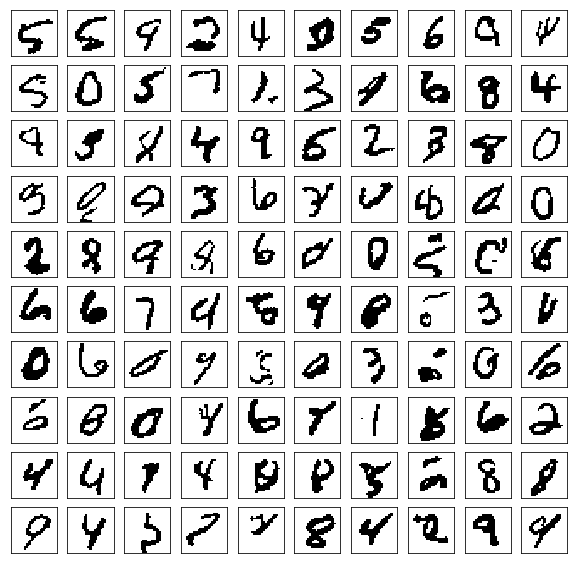

In [14]:
# Generating new images
samples = np.zeros((100, height, width, n_channel), dtype='float32')
for i in range(height):
    for j in range(width):
        logits = pixelcnn(samples)
        next_sample = tf.random.categorical(logits[:, i, j, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:, 0]

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

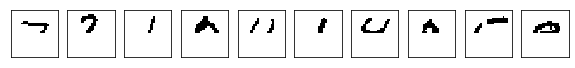

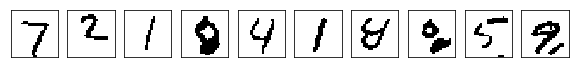

In [15]:
# Filling occluded images
occlude_start_row = 14
num_generated_images = 10
samples = np.copy(x_test_quantised[0:num_generated_images, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

for i in range(occlude_start_row, height):
    for j in range(width):
        logits = pixelcnn(samples)
        next_sample = tf.random.categorical(logits[:, i, j, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:, 0]

fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

That's looks great, so now let's check with 256 levels.

In [16]:
# --------------------------------------------------------------------------------------------------------------
# Quantise the input data in q levels
q_levels = 256
x_train_quantised = quantise(x_train, q_levels)
x_test_quantised = quantise(x_test, q_levels)

# --------------------------------------------------------------------------------------------------------------
# Creating input stream using tf.data API
batch_size = 256
train_buf = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)

# --------------------------------------------------------------------------------------------------------------
# Create PixelCNN model
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=128, kernel_size=7, strides=1)(inputs)

for i in range(15):
    x = ResidualBlock(h=64)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=q_levels, kernel_size=1, strides=1)(x)

pixelcnn = keras.Model(inputs=inputs, outputs=x)

# --------------------------------------------------------------------------------------------------------------
# Prepare optimizer and loss function
lr_decay = 0.999995
learning_rate = 1e-3
optimizer = keras.optimizers.Adam(lr=learning_rate)

compute_loss = keras.losses.CategoricalCrossentropy(from_logits=True)

# --------------------------------------------------------------------------------------------------------------
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn(batch_x, training=True)

        loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))

    return loss

# --------------------------------------------------------------------------------------------------------------
# Training loop
n_epochs = 100
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    progbar = Progbar(n_iter)
    print('Epoch {:}/{:}'.format(epoch + 1, n_epochs))

    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)

        progbar.add(1, values=[('loss', loss)])

Epoch 1/100
235/235 [==============================] - 75s 317ms/step - loss: 1.0547
Epoch 2/100
235/235 [==============================] - 71s 302ms/step - loss: 0.7940
Epoch 3/100
235/235 [==============================] - 71s 303ms/step - loss: 0.7780
Epoch 4/100
235/235 [==============================] - 72s 306ms/step - loss: 0.7669
Epoch 5/100
235/235 [==============================] - 71s 302ms/step - loss: 0.7587
Epoch 6/100
235/235 [==============================] - 71s 302ms/step - loss: 0.7519
Epoch 7/100
235/235 [==============================] - 71s 302ms/step - loss: 0.7470
Epoch 8/100
235/235 [==============================] - 71s 303ms/step - loss: 0.7418
Epoch 9/100
235/235 [==============================] - 72s 305ms/step - loss: 0.7382
Epoch 10/100
235/235 [==============================] - 71s 301ms/step - loss: 0.7346
Epoch 11/100
235/235 [==============================] - 72s 306ms/step - loss: 0.7311
Epoch 12/100
235/235 [==============================] - 71s 302

235/235 [==============================] - 71s 301ms/step - loss: 0.6359
Epoch 97/100
235/235 [==============================] - 71s 301ms/step - loss: 0.6214
Epoch 98/100
235/235 [==============================] - 71s 303ms/step - loss: 0.6407
Epoch 99/100
235/235 [==============================] - 71s 303ms/step - loss: 0.6181
Epoch 100/100
235/235 [==============================] - 71s 300ms/step - loss: 0.6457


In [ ]:
# Test set performance
test_loss = []
for batch_x, batch_y in test_dataset:
    logits = pixelcnn(batch_x, training=False)

    # Calculate cross-entropy (= negative log-likelihood)
    loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    test_loss.append(loss)
print('nll : {:} nats'.format(np.array(test_loss).mean()))
print('bits/dim : {:}'.format(np.array(test_loss).mean() / np.log(2)))

In [17]:
# Generating new images
samples = np.zeros((100, height, width, n_channel), dtype='float32')
for i in range(height):
    for j in range(width):
        logits = pixelcnn(samples)
        next_sample = tf.random.categorical(logits[:, i, j, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:, 0]

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

nll : 0.6275386214256287 nats
bits/dim : 0.9053468570970511


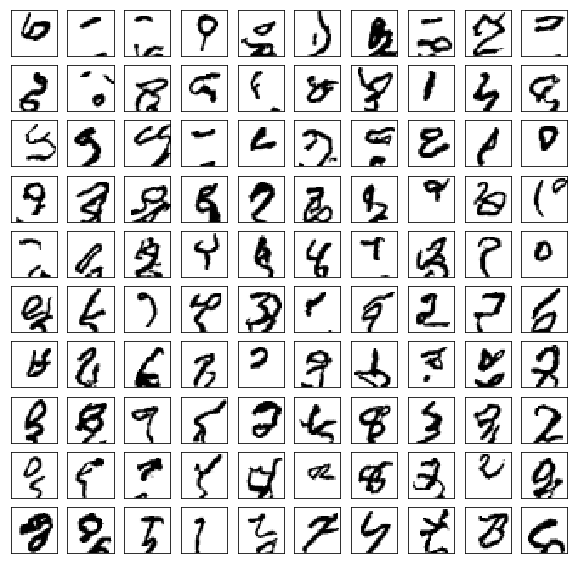

In [18]:
# Generating new images
samples = np.zeros((100, height, width, n_channel), dtype='float32')
for i in range(height):
    for j in range(width):
        logits = pixelcnn(samples)
        next_sample = tf.random.categorical(logits[:, i, j, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:, 0]

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

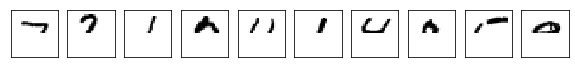

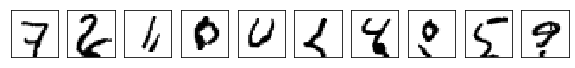

In [19]:
# Filling occluded images
occlude_start_row = 14
num_generated_images = 10
samples = np.copy(x_test_quantised[0:num_generated_images, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

for i in range(occlude_start_row, height):
    for j in range(width):
        logits = pixelcnn(samples)
        next_sample = tf.random.categorical(logits[:, i, j, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:, 0]

fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

Because of the higher number of dimensions, the challenge of predicting the conditional probability becomes harder, but even so, the results look very interesting! This is the very first PixelCNN model and a few other implementations have been released that use novel and state-of-the-art techniques to obtain great results. We are going to delve into them in future notebooks/blogposts.
